# Advanced RNNs: LSTM

Goal of the lab is to:
    * Understand and implement parts of LSTM
    
References:
    * http://colah.github.io/posts/2015-08-Understanding-LSTMs/ (good ref. for the general equations)
    * https://ytd2525.wordpress.com/2016/08/03/understanding-deriving-and-extending-the-lstm/ (more in depth journey through LSTM variants)
    * http://nicodjimenez.github.io/2014/08/08/lstm.html (explains well constant error carousel)

# Whiteboard exercises

(Any left out exercise from the previous labs)

* (0.5) Describe the main difference between GRU and LSTM. What is the intuition behind GRU? 

* (0.5) Describe the peephole connection variant of LSTM. What is the intuition behind peephole connection?

* (0.5) Describe what is the "shadow state" in LSTM. See: https://ytd2525.wordpress.com/2016/08/03/understanding-deriving-and-extending-the-lstm/

# Setup

In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from collections import defaultdict
import math
import torch
from torch.nn import Module, Parameter
import torch.nn.functional as F
from torch.autograd import Variable
%matplotlib inline
import json
import matplotlib.pylab as plt

In [2]:
# Hyper Parameters (constant for the notebook)
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64
LR = 0.001
TIME_STEP = 28          # rnn time step / image height
INPUT_SIZE = 28         # rnn input size / image width
LR = 0.01               # learning rate
DOWNLOAD_MNIST = True   # set to True if haven't download the data

In [3]:
# A standard way to load a dataset
train_data = dsets.MNIST(
    root='./mnist/',
    train=True,                         # this is training data
    transform=transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                        # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,            # download it if you don't have it
)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
# convert test data into Variable, pick 2000 samples to speed up testing
test_data = dsets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor())
# shape (2000, 28, 28) value in range(0,1)
test_x = Variable(test_data.test_data, volatile=True).type(torch.FloatTensor)[:2000]/255.   
test_y = test_data.test_labels.numpy().squeeze()[:2000]    # covert to numpy array

# Exercise 1: Code LSTM

Reference: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

Fill in the missing blanks. Train a single epoch, and save a plot of accuracy to ``10b_ex1.png``.

In [17]:
class LSTMCell(Module):

    def __init__(self, input_size, hidden_size, bias=True, grad_clip=None):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.w = nn.Linear(hidden_size + input_size, 4 * hidden_size, bias=bias)
        
#         Note: parameters are initialized for you, but feel free to change this
#         the suggested way of implementing forward is computing all inputs to
#         gates at once by using a D -> 4*D linear layer
#         self.weight_ih = Parameter(torch.Tensor(4 * hidden_size, input_size))
#         self.weight_hh = Parameter(torch.Tensor(4 * hidden_size, hidden_size))
#         if bias:
#             self.bias = Parameter(torch.Tensor(4 * hidden_size))
#         else:
#             self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, input, hx):
        h, c = hx
        combined = torch.cat((h, input), dim=-1)      
        mid = self.w(combined)
        # Compute input (i), forget (f), g (marked as \tilde{C_t} in Colah), output (o),
        # state (c) and hidden state (h)
        # For reference see http://colah.github.io/posts/2015-08-Understanding-LSTMs/ 
        f = F.sigmoid(mid[:, :self.hidden_size])
        i = F.sigmoid(mid[:, self.hidden_size:2*self.hidden_size])
        g = F.tanh(mid[:, 2*self.hidden_size:3*self.hidden_size])
        o = F.sigmoid(mid[:, 3*self.hidden_size:])
        c = f * c + i * g
        h = o * F.tanh(c)
        return h, c

In [18]:
class LSTM(Module):

    def __init__(self, input_size, hidden_size, recurrent_size=None, bias=True, 
                 return_sequences=True, grad_clip=None):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.recurrent_size = recurrent_size
        self.bias = bias
        self.return_sequences = return_sequences
        self.grad_clip = grad_clip

        Cell = LSTMCell

        kwargs = {'input_size': input_size,
                  'hidden_size': hidden_size,
                  'bias': bias,
                  'grad_clip': grad_clip}

        self.cell0 = Cell(**kwargs)
        
    def forward(self, input, initial_states=None):
        if initial_states is None:
            zeros = Variable(torch.zeros(input.size(0), self.hidden_size))
            initial_states = [(zeros, zeros), ]

        states = initial_states
        outputs = []

        # Note: Similar to code we wrote in 10a_rnn.
        
        time_steps = input.size(1)
        for t in range(time_steps):
            x = input[:, t, :]
            hx = self.cell0(x, states[0])
            states[0] = hx
            x = hx[0]
            outputs.append(hx)

        if self.return_sequences:
            hs, cs = zip(*outputs)
            h = torch.stack(hs).transpose(0, 1)
            c = torch.stack(cs).transpose(0, 1)
            output = (h, c)
        else:
            output = outputs[-1]
        return output

In [19]:
rnn = LSTM(28, 64, return_sequences=False)
clf = nn.Linear(64, 10)

In [20]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

In [21]:
# training and testing
H = {"acc": []}
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y
        
        optimizer.zero_grad()

        hidden, state = rnn.forward(b_x)
        output = clf.forward(hidden)
        loss = loss_func(output, b_y)
        
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            hidden, state = rnn.forward(test_x)
            test_output = clf.forward(hidden)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y.reshape(-1,)) / float(test_y.size)
            H['acc'].append(accuracy)
            print('train loss: %.4f' % loss.data[0], '| test accuracy: %.2f' % accuracy)

train loss: 2.3172 | test accuracy: 0.10
train loss: 1.1902 | test accuracy: 0.60
train loss: 1.0963 | test accuracy: 0.71
train loss: 0.8302 | test accuracy: 0.79
train loss: 1.0175 | test accuracy: 0.81
train loss: 0.6931 | test accuracy: 0.85
train loss: 0.6774 | test accuracy: 0.88
train loss: 0.6167 | test accuracy: 0.89
train loss: 0.5064 | test accuracy: 0.88
train loss: 0.4290 | test accuracy: 0.90
train loss: 0.4235 | test accuracy: 0.93
train loss: 0.3988 | test accuracy: 0.91
train loss: 0.5147 | test accuracy: 0.92
train loss: 0.3903 | test accuracy: 0.93
train loss: 0.4846 | test accuracy: 0.91
train loss: 0.5166 | test accuracy: 0.93
train loss: 0.4209 | test accuracy: 0.92
train loss: 0.5453 | test accuracy: 0.91
train loss: 0.4219 | test accuracy: 0.94


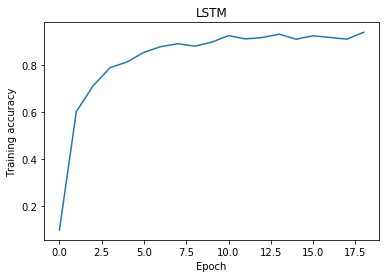

In [22]:
plt.title("LSTM")
plt.plot(H['acc'])
plt.xlabel("Epoch")
plt.ylabel("Training accuracy")
plt.savefig("10b_ex1.png")